In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.layers import Dense, Flatten,Dropout,PReLU
from tensorflow.keras.layers import Dense, BatchNormalization,Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
import pathlib
data_dir=r'D:\21phd7151\All Gamm\gammfiltaug'
data_dir = pathlib.Path(data_dir)


In [3]:
Spect_images_dict = {
    'N': list(data_dir.glob('N/*')),
    'AS': list(data_dir.glob('AS/*')),
    'MR': list(data_dir.glob('MR/*')),
    'MS': list(data_dir.glob('MS/*')),
    'MVP': list(data_dir.glob('MVP/*')),
}


In [4]:
Spect_labels_dict = {
    'N': 0,
    'AS': 1,
    'MR': 2,
    'MS': 3,
    'MVP': 4
}


In [5]:
import numpy as np
import cv2

X, y = [], []

for Spect_name, images in Spect_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        #resized_img = cv2.resize(img,(224,224))
        resized_img = cv2.resize(img,(224,224),Image.Resampling.BICUBIC)
        #resized_img = cv2.resize(img,(224,224),Image.BICUBIC)
        X.append(resized_img)
        #X.append(img)
        y.append(Spect_labels_dict[Spect_name])

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, random_state = 42, stratify = y)

In [8]:
val_split = 0.1

val_indices = int(len(X_train) * val_split)
new_x_train, new_y_train = X_train[val_indices:], y_train[val_indices:]
x_val, y_val = X_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(X_test)}")

Training data samples: 3600
Validation data samples: 400
Test data samples: 1000


In [9]:
image_size = 224
batch_size = 256
auto = tf.data.AUTOTUNE

augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip("horizontal"),
]


def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(X_test, y_test)

In [10]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=224, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=5
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 30

In [ ]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

In [11]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)


In [12]:

conv_base.trainable = True

set_trainable = False


for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
   
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

    
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [27]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Conv2D, Activation, BatchNormalization, Input, GlobalAveragePooling2D
from keras.layers import DepthwiseConv2D

def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = DepthwiseConv2D(kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("gelu")(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("gelu")(x)
    x = x + x0  # Residual connection
    return x

# Define the input tensor
inputs = Input(shape=(224, 224, 3))

# Load the VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# Get the output tensor of the VGG16 model
vgg16_output = conv_base.output

# Adjust the number of filters to match the output of the VGG16 model
conv_mixer_output = conv_mixer_block(vgg16_output, filters=512, kernel_size=3)  # Adjusted filters to 512


# Compile and train the combined model as needed
x = GlobalAveragePooling2D()(conv_mixer_output)

# Add a dense layer with ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout layer for regularization (optional)
# x = Dropout(0.5)(x)

# Add the output layer for classification with softmax activation
predictions = Dense(5, activation='softmax')(x)  # Assuming 5 classes

# Create a new model with the VGG16 input and the new classification layers
combined_model = Model(inputs=conv_base.input, outputs=predictions)

In [28]:
combined_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [29]:
combined_model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [30]:
history = combined_model.fit(
    new_x_train, new_y_train,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=2,
    epochs=30
)


Epoch 1/30
113/113 - 225s - loss: 0.2757 - accuracy: 0.9244 - val_loss: 0.1398 - val_accuracy: 0.9650 - 225s/epoch - 2s/step
Epoch 2/30
113/113 - 215s - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0858 - val_accuracy: 0.9700 - 215s/epoch - 2s/step
Epoch 3/30
113/113 - 211s - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0562 - val_accuracy: 0.9800 - 211s/epoch - 2s/step
Epoch 4/30
113/113 - 213s - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0794 - val_accuracy: 0.9800 - 213s/epoch - 2s/step
Epoch 5/30
113/113 - 211s - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0733 - val_accuracy: 0.9800 - 211s/epoch - 2s/step
Epoch 6/30
113/113 - 213s - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0984 - val_accuracy: 0.9700 - 213s/epoch - 2s/step
Epoch 7/30
113/113 - 210s - loss: 0.0146 - accuracy: 0.9947 - val_loss: 0.0608 - val_accuracy: 0.9850 - 210s/epoch - 2s/step
Epoch 8/30
113/113 - 210s - loss: 0.0088 - accuracy: 0.9967 - val_loss: 0.0786 - val_accuracy: 0.9750 - 210s/epoch - 2s/step


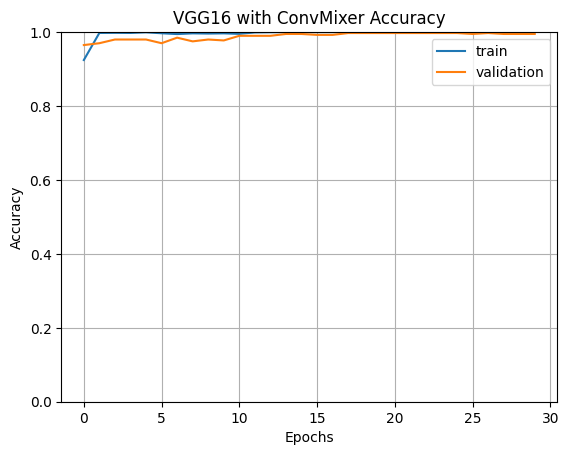

In [31]:
import matplotlib.pyplot as plt
 

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.,ymax=1)
plt.grid()
plt.title('VGG16 with ConvMixer Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("ConvMixergamm2.pdf")
plt.show()


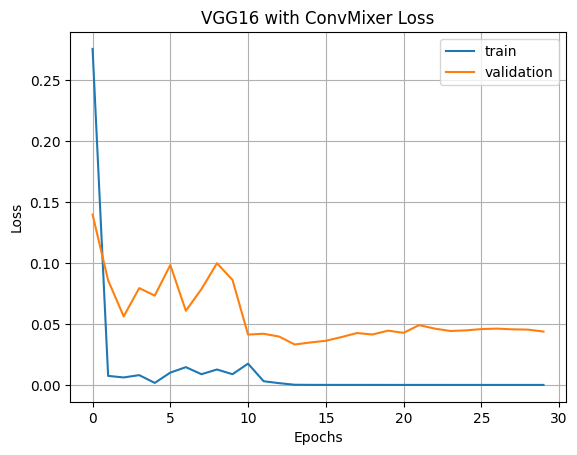

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('VGG16 with ConvMixer Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("ConvMixergammloss2.pdf")
plt.show()

In [40]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
pred=combined_model.predict(X_test)
pred=np.array(pred)
y_eval=np.array(y_test)
print(y_eval.shape,pred.shape)
print(y_eval,pred)

32/32 [==============================] - 44s 1s/step
(1000,) (1000, 5)
[1 3 0 2 2 0 0 1 0 2 2 1 0 0 2 4 0 2 1 3 4 2 4 4 0 3 2 2 0 3 4 3 2 2 0 3 0
 2 2 4 0 0 3 2 0 2 3 4 1 3 2 1 3 1 2 3 3 0 3 3 1 0 1 0 1 3 4 3 3 2 4 1 0 2
 0 0 4 1 4 0 0 2 2 4 1 0 3 1 1 4 3 2 1 3 2 3 2 4 1 3 0 3 1 2 2 3 3 4 3 1 4
 2 4 3 0 1 0 3 2 1 3 0 1 1 1 1 0 0 4 0 4 4 0 3 0 4 4 4 4 2 3 1 4 4 1 0 4 3
 4 3 0 2 1 0 3 3 4 2 0 3 4 4 0 4 3 4 1 4 4 2 4 2 0 0 4 2 0 2 4 2 3 2 2 1 0
 0 0 1 1 4 0 3 0 0 1 3 4 2 2 0 2 3 2 4 0 2 2 1 4 3 2 1 3 4 3 3 4 3 0 1 1 4
 0 3 4 4 4 1 4 4 3 0 2 0 2 0 3 4 3 2 1 4 3 0 2 2 4 2 1 1 4 4 0 2 4 1 2 2 4
 4 1 4 0 1 0 0 1 3 0 4 4 3 1 4 1 2 1 0 1 2 0 1 3 1 2 4 0 1 0 0 2 3 2 0 2 2
 2 0 3 1 2 3 1 2 4 3 3 1 4 3 4 4 3 0 1 4 4 0 0 1 2 2 0 3 1 3 0 2 3 0 4 0 4
 3 0 1 2 2 4 4 3 2 4 2 0 3 4 1 1 1 2 4 0 2 1 0 3 3 3 3 2 2 2 3 2 2 4 4 0 0
 4 4 4 3 2 1 0 4 3 2 1 2 3 1 3 3 4 1 4 2 2 0 0 3 2 4 3 3 4 1 4 4 4 3 0 2 0
 4 0 2 4 1 0 3 1 0 0 2 3 3 2 3 4 2 2 2 3 3 0 3 3 1 1 3 1 0 1 2 4 2 4 1 3 0
 4 2 0 2 2 1 2 4 2 3 0 1 3 4 

In [41]:
import numpy as np
pred=np.argmax(combined_model.predict(X_test),axis=-1)

from sklearn.metrics import classification_report
print(classification_report(y_eval,pred,digits=4))


32/32 [==============================] - 45s 1s/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       200
           1     1.0000    1.0000    1.0000       200
           2     1.0000    0.9850    0.9924       200
           3     0.9901    1.0000    0.9950       200
           4     0.9900    0.9950    0.9925       200

    accuracy                         0.9960      1000
   macro avg     0.9960    0.9960    0.9960      1000
weighted avg     0.9960    0.9960    0.9960      1000



In [35]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
pred2=combined_model.predict(x_val)
pred2=np.array(pred2)
y_eval2=np.array(y_val)
print(y_eval2.shape,pred2.shape)
print(y_eval2,pred2)

13/13 [==============================] - 17s 1s/step
(400,) (400, 5)
[1 4 4 3 0 2 0 2 0 2 2 0 3 2 3 0 4 3 0 0 3 2 2 1 3 2 4 2 3 2 0 1 4 3 0 2 4
 3 2 2 4 0 1 0 2 4 3 0 1 0 4 4 1 0 0 0 2 3 3 2 2 4 1 3 3 1 2 4 2 1 2 3 3 1
 2 0 4 4 1 3 2 2 3 0 3 1 3 3 2 2 0 1 4 2 3 4 4 0 0 1 4 1 4 3 2 1 0 3 1 3 2
 3 4 4 3 1 3 2 3 4 3 0 4 0 0 4 2 0 2 4 1 2 0 4 4 3 0 2 4 0 3 1 2 0 2 4 0 2
 4 3 2 0 0 2 2 3 1 0 4 3 3 2 4 1 2 2 2 1 4 2 0 4 4 4 2 2 1 4 2 2 1 1 1 3 1
 4 2 4 2 4 0 2 2 0 3 2 1 2 2 4 2 1 3 3 4 4 0 2 2 1 0 1 3 3 1 3 4 0 4 4 3 2
 3 4 1 0 0 2 1 4 3 4 2 2 2 4 0 4 3 3 3 3 2 4 0 2 0 1 0 1 3 2 4 1 3 2 0 1 1
 0 0 2 4 1 1 1 0 3 2 1 0 1 1 1 2 3 2 1 2 0 1 3 0 3 3 1 3 4 4 4 4 4 0 2 2 0
 0 4 0 2 4 3 0 0 4 0 0 2 2 3 0 4 3 0 0 4 1 1 3 2 0 3 4 4 3 2 4 4 1 1 4 1 2
 1 4 2 3 3 0 0 1 0 4 2 4 3 4 2 2 1 3 0 3 2 1 3 0 4 1 2 1 0 0 3 3 3 3 4 2 2
 1 4 1 2 2 1 3 2 3 1 2 1 0 0 0 1 2 1 1 4 2 1 4 1 4 4 3 2 0 1] [[1.4945767e-08 9.9999917e-01 7.3200715e-07 4.3671584e-08 4.3621302e-08]
 [7.2906271e-11 6.1718730e-10 3.1300448e-10 1.

In [36]:

import numpy as np
pred=np.argmax(combined_model.predict(x_val),axis=-1)

from sklearn.metrics import classification_report
print(classification_report(y_val,pred,digits=4))
plt.savefig("metrics_vgg16allgtcc.pdf")

13/13 [==============================] - 17s 1s/step
              precision    recall  f1-score   support

           0     0.9870    1.0000    0.9935        76
           1     1.0000    1.0000    1.0000        72
           2     1.0000    0.9895    0.9947        95
           3     1.0000    1.0000    1.0000        77
           4     0.9875    0.9875    0.9875        80

    accuracy                         0.9950       400
   macro avg     0.9949    0.9954    0.9951       400
weighted avg     0.9950    0.9950    0.9950       400



<Figure size 640x480 with 0 Axes>

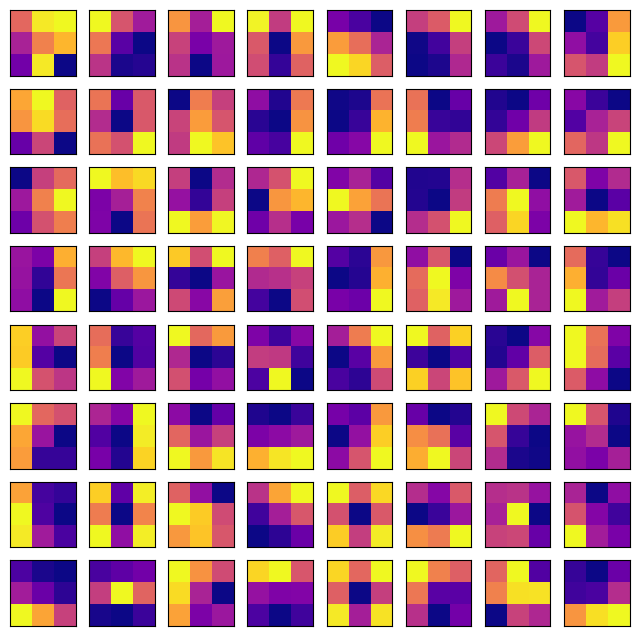

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualization_plot(weights, idx=1, cmap='plasma'):
    # Visualize all the filters.
    num_filters = weights.shape[-1]
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        ax = plt.subplot(8, 8, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight.mean(axis=-1), cmap=cmap)  # Visualize filter with specified colormap
        idx += 1

# Assuming you have the ConvMixer model stored in combined_model variable
# We first visualize the learned weights of the first convolutional layer.
conv_layer_weights = combined_model.layers[2].get_weights()[0]  # Assuming the convolutional layer is at index 2
visualization_plot(conv_layer_weights, cmap='plasma')  # Change the colormap here
plt.show()


ValueError: num must be an integer with 1 <= num <= 64, not 65

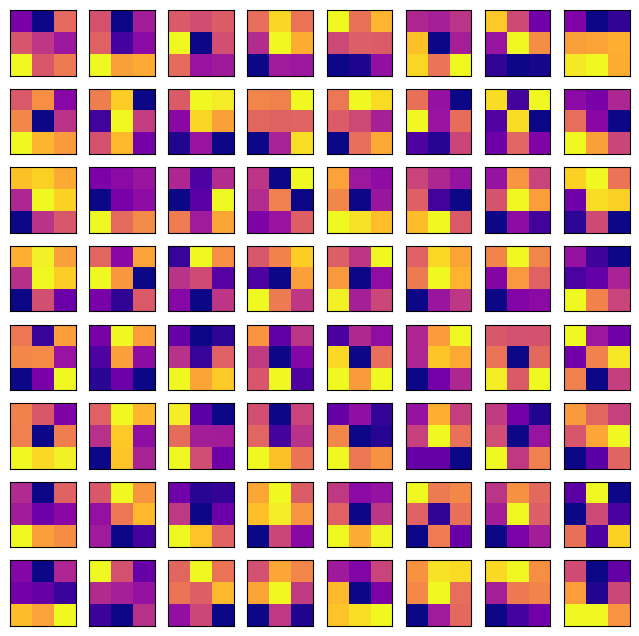

In [38]:
for i, layer in enumerate(combined_model.layers):
    if isinstance(layer, layers.Conv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 22 # Taking a kernel from the middle of the network.

kernel = combined_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import metrics
confusion_matrix =metrics.confusion_matrix(y_eval,pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix,display_labels= [0,1,2,3,4])

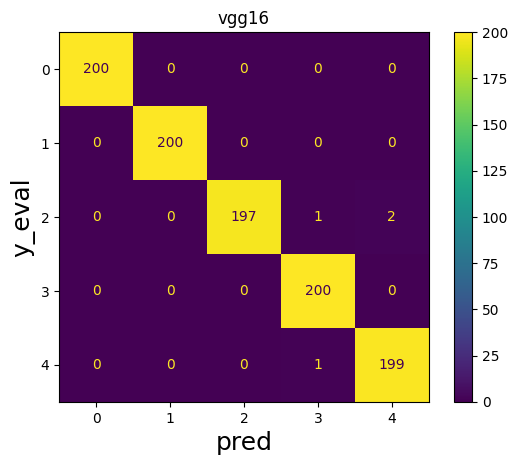

In [43]:
cm_display1= cm_display.plot()
# Set the font size of xticks
plt.title('vgg16')
plt.xlabel('pred',fontsize=18)
plt.ylabel('y_eval',fontsize=18)
plt.savefig("cm_gamm_conmixvgg.pdf")

plt.show()

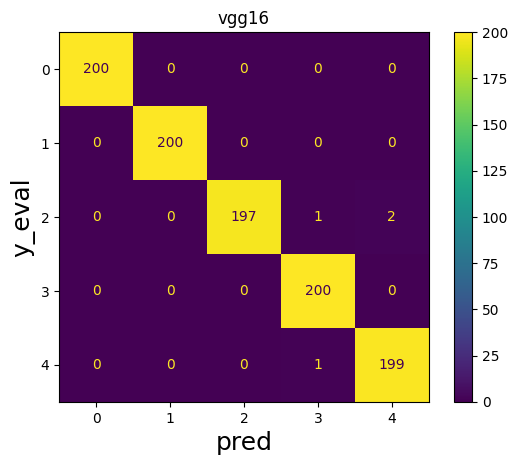

In [44]:
cm_display1= cm_display.plot()
# Set the font size of xticks
plt.title('vgg16')
plt.xlabel('pred',fontsize=18)
plt.ylabel('y_eval',fontsize=18)
plt.savefig("cm_gamm_conmixvgg.pdf")

plt.show()

In [45]:
# Assuming combined_model is your Keras model
combined_model.save("mymodel_march20.h5")


C:\Users\VIT-AP\.conda\envs\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def grad_cam(model, img_path, layer_name, class_index, heatmap_path):
    # Load the image
    img  = r'D:\21phd7151\All Gamm\gammfiltaug\AS\Gamm_AS (1).jpg'
    target_size=(224, 224)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
 

    # Get the target layer
    target_layer = model.get_layer(layer_name)
    model = tf.keras.Model(inputs=model.inputs, outputs=target_layer.output)

    # Calculate gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output = model(img_array)
        class_output = last_conv_layer_output[:, :, :, class_index]
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Calculate the mean gradient values over each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its corresponding gradient value
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to eliminate negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    # Convert heatmap to RGB format
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = tf.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.grayscale_to_rgb(heatmap)
    heatmap = heatmap.numpy()

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * 0.4 + img_array[0]
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 255.0)
    superimposed_img = superimposed_img.numpy().astype(np.uint8)

    # Save the superimposed image
    save_path = heatmap_path
    tf.keras.preprocessing.image.save_img(save_path, superimposed_img)



In [47]:
def grad_cam(model, img_path, layer_name, class_index, heatmap_path):
    # Load the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Get the target layer
    target_layer = model.get_layer(layer_name)
    model = tf.keras.Model(inputs=model.inputs, outputs=target_layer.output)

    # Calculate gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output = model(img_array)
        class_output = last_conv_layer_output[:, :, :, class_index]
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Calculate the mean gradient values over each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its corresponding gradient value
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to eliminate negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    # Convert heatmap to RGB format
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = tf.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.grayscale_to_rgb(heatmap)
    heatmap = heatmap.numpy()

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * 0.4 + img_array[0]
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 255.0)
    superimposed_img = superimposed_img.numpy().astype(np.uint8)

    # Save the superimposed image
    save_path = heatmap_path
    tf.keras.preprocessing.image.save_img(save_path, superimposed_img)


In [51]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image
img_path = 'D:\\21phd7151\\All Gamm\\gammfiltaug\\AS\\Gamm_AS (1).jpg'
img = load_img(img_path, target_size=(224, 224))

# Convert the image to an array
img_array = img_to_array(img)

# Call grad_cam function with the loaded image array
grad_cam(combined_model, img_array, 'block5_conv3', class_index=0, heatmap_path='heatmap.jpg')


ValueError: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def grad_cam(model, img_array, layer_name, class_index, heatmap_path):
    # Get the target layer
    target_layer = model.get_layer(layer_name)
    model = tf.keras.Model(inputs=model.inputs, outputs=target_layer.output)

    # Calculate gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output = model(img_array)
        class_output = last_conv_layer_output[:, :, :, class_index]
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Calculate the mean gradient values over each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its corresponding gradient value
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to eliminate negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    # Convert heatmap to RGB format
    if len(heatmap.shape) == 2:
        heatmap = tf.expand_dims(heatmap, axis=-1)
        heatmap = tf.image.resize(heatmap, (img_array.shape[1], img_array.shape[2]))
        heatmap = tf.expand_dims(heatmap, axis=0)  # Add batch dimension
        heatmap = tf.image.grayscale_to_rgb(heatmap)


    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * 0.4 + img_array[0]
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 255.0)
    superimposed_img = superimposed_img.numpy().astype(np.uint8)

    # Save the superimposed image
    save_path = heatmap_path
    tf.keras.preprocessing.image.save_img(save_path, superimposed_img)


In [62]:
# Reshape input data to match the model's expected shape
img_array = img_array.reshape((224, 224, 3))
# Add an extra dimension to the input data
img_array = np.expand_dims(img_array, axis=0)
# Remove the extra dimension added by np.expand_dims()
img_array = img_array[0]


grad_cam(combined_model, img_array, 'block5_conv3', class_index=0, heatmap_path='heatmap.jpg')


ValueError: Input 0 of layer "model_10" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)

In [ ]:
combined_model.summary()

In [53]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [54]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

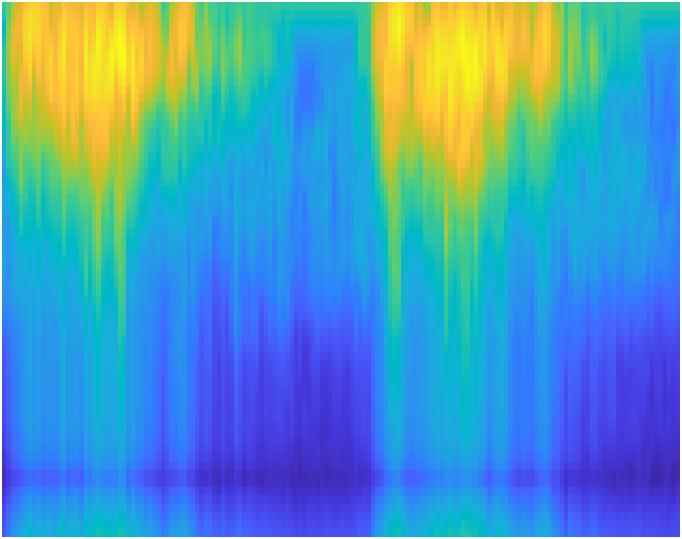

In [55]:

img_size = (224, 224)
#preprocess_input = combined_model.preprocess_input
#decode_predictions = combined_model.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = r"D:\21phd7151\All Gamm\gammfiltaug\AS\Gamm_AS (1).jpg"


display(Image(img_path))

1/1 [==============================] - 0s 118ms/step


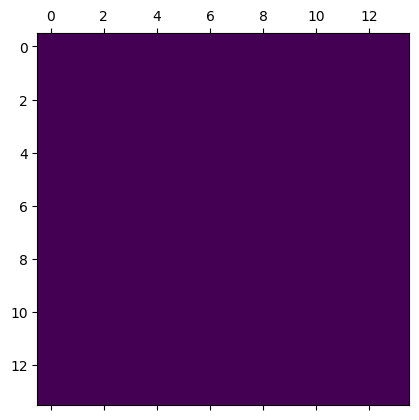

In [61]:
model = combined_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [57]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values


1/1 [==============================] - 0s 146ms/step


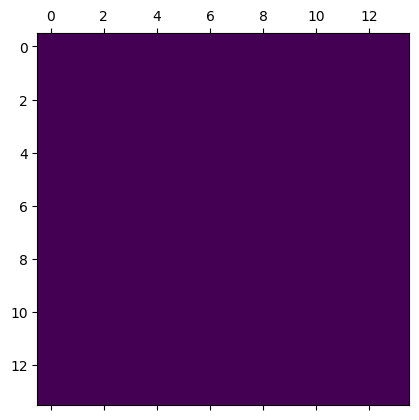

In [60]:
model = combined_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

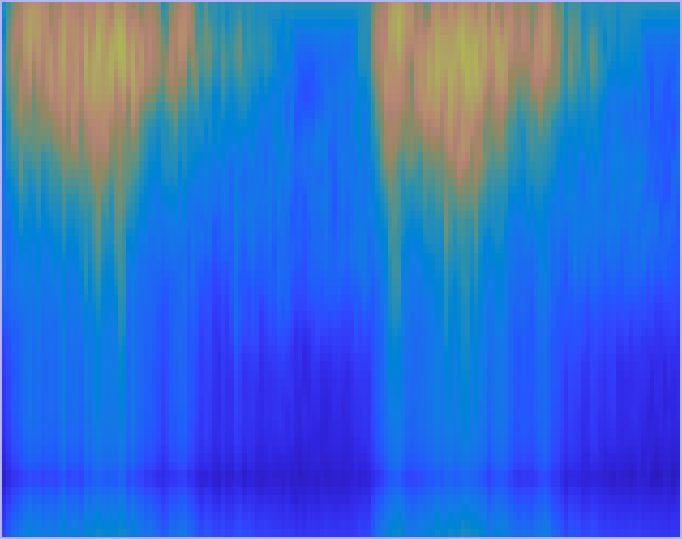

In [59]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
# Assuming your model is named combined_model
combined_model.save("mymar19vgg.h5")


32/32 [==============================] - 44s 1s/step


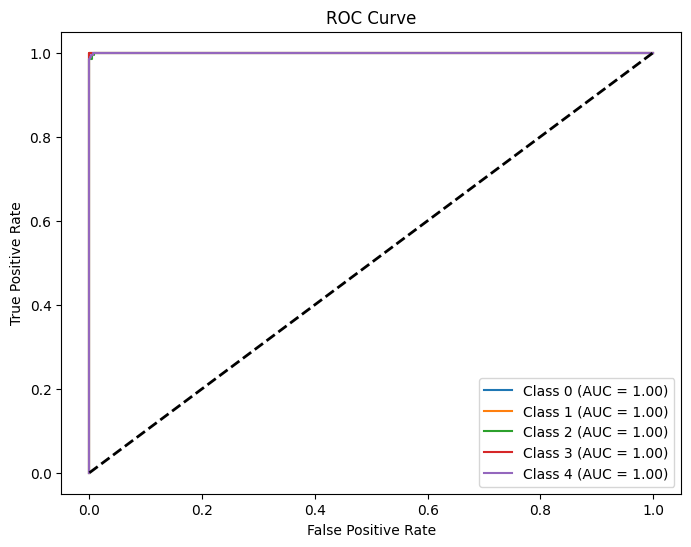

In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming your combined model is named 'combined_model'

# Make predictions on the ECG test data
pcg_pred = combined_model.predict([X_test])

# Convert the true labels to binary format
pcg_true_labels_binary = label_binarize(y_eval, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(pcg_true_labels_binary.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(pcg_true_labels_binary[:, i], pcg_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(pcg_true_labels_binary.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

